In [15]:
from SPARQLWrapper import SPARQLWrapper, JSON

# Define the DBpedia SPARQL endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

# Write a SPARQL query to fetch only the birthdate of Albert Einstein
query = """
    SELECT ?birthDate
    WHERE {
      dbr:Roger_Federer dbo:birthDate ?birthDate .
    }
    LIMIT 1
"""

# Set the query and the return format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)

# Execute the query and fetch results
results = sparql.query().convert()

# Process and display the birthdate
if results["results"]["bindings"]:
    birthdate = results["results"]["bindings"][0]["birthDate"]["value"]
    print(f"Roger Federer's birthdate: {birthdate}")
else:
    print("No birthdate found.")

Roger Federer's birthdate: 1981-08-08


In [1]:
import sqlite3
import pandas as pd


def create_and_populate_database_with_composite_key(db_path, df):
    # Connect to SQLite database (it will create the file if it doesn't exist)
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Drop tables if they exist to ensure a clean start
    cursor.execute("DROP TABLE IF EXISTS tournament;")
    cursor.execute("DROP TABLE IF EXISTS tennis_match;")

    # Create tournaments table
    cursor.execute('''
        CREATE TABLE tournament (
            tourney_id TEXT PRIMARY KEY,
            tourney_name TEXT,
            surface TEXT,
            draw_size INTEGER,
            tourney_level TEXT,
            tourney_date INTEGER
        );
    ''')

    # Create matches table with a composite primary key on tourney_id and match_num
    cursor.execute('''
        CREATE TABLE tennis_match (
            match_num INTEGER,
            tourney_id TEXT,
            winner_id INTEGER,
            winner_seed TEXT,
            winner_entry TEXT,
            winner_name TEXT,
            winner_hand TEXT,
            winner_ht REAL,
            winner_ioc TEXT,
            winner_age REAL,
            loser_id INTEGER,
            loser_seed TEXT,
            loser_entry TEXT,
            loser_name TEXT,
            loser_hand TEXT,
            loser_ht REAL,
            loser_ioc TEXT,
            loser_age REAL,
            score TEXT,
            best_of INTEGER,
            round TEXT,
            minutes INTEGER,
            w_ace INTEGER,
            w_df INTEGER,
            w_svpt INTEGER,
            w_1stIn INTEGER,
            w_1stWon INTEGER,
            w_2ndWon INTEGER,
            w_SvGms INTEGER,
            w_bpSaved INTEGER,
            w_bpFaced INTEGER,
            l_ace INTEGER,
            l_df INTEGER,
            l_svpt INTEGER,
            l_1stIn INTEGER,
            l_1stWon INTEGER,
            l_2ndWon INTEGER,
            l_SvGms INTEGER,
            l_bpSaved INTEGER,
            l_bpFaced INTEGER,
            winner_rank REAL,
            winner_rank_points REAL,
            loser_rank REAL,
            loser_rank_points REAL,
            PRIMARY KEY (match_num, tourney_id),
            FOREIGN KEY (tourney_id) REFERENCES tournaments(tourney_id)
        );
    ''')

    # Extract unique tournament data and insert into tournaments table
    tournament_data = df[['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date']].drop_duplicates()
    tournament_data.to_sql('tournament', conn, if_exists='append', index=False)

    # Insert match data into matches table
    match_data = df.drop(columns=['tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date'])
    match_data.to_sql('tennis_match', conn, if_exists='append', index=False)

    # Commit changes and close the connection
    conn.commit()
    conn.close()
    print(f"Database created and populated at {db_path} with composite key on matches table.")

# Load the CSV into a DataFrame
df = pd.read_csv("persistence/atpMatches/atp_matches_2024.csv")

# Update the database path to include a file name
db_path = "persistence/atpMatches/atp_tournaments.db"

# Call the function with the correct db_path and loaded DataFrame
create_and_populate_database_with_composite_key(db_path, df)

Database created and populated at atpMatches/atp_tournaments.db with composite key on matches table.


In [39]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import FOAF

# DBpedia SPARQL endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

def create_player_knowledge_graph(player_uri):
    """
    Queries DBpedia for player information and adds custom achievements if provided.
    
    :param player_uri: The DBpedia URI for the player
    :param custom_achievements: A dictionary of custom achievements (e.g., {"ATP Titles": 103})
    :return: RDF knowledge graph
    """
    # Initialize a new RDF graph
    graph = Graph()
    dbo = Namespace("http://dbpedia.org/ontology/")
    ex = Namespace("http://example.org/tennis/")
    graph.bind("dbo", dbo)
    graph.bind("foaf", FOAF)
    graph.bind("ex", ex)  # Custom namespace for custom achievements

    # Construct the SPARQL query using the provided URI
    detail_query = f"""
    SELECT ?birthDate ?birthPlace ?height ?singlesTitles WHERE {{
      <{player_uri}> dbo:birthDate ?birthDate .
      OPTIONAL {{ <{player_uri}> dbo:birthPlace ?birthPlace }}
      OPTIONAL {{ <{player_uri}> dbo:height ?height }}
      OPTIONAL {{ <{player_uri}> dbo:singlesTitles ?singlesTitles }}  # Add other fields as needed
    }} LIMIT 1
    """

    # Set up and execute the query
    sparql.setQuery(detail_query)
    sparql.setReturnFormat(JSON)

    try:
        details = sparql.query().convert()
        print("Detail query results:", details)  # Print detail query results for verification

        # Add the player URI as a node in the RDF graph
        player_node = URIRef(player_uri)
        graph.add((player_node, FOAF.name, Literal(player_uri.split('/')[-1])))

        # Process and add details to the graph
        for result in details["results"]["bindings"]:
            if "birthDate" in result:
                graph.add((player_node, dbo.birthDate, Literal(result["birthDate"]["value"])))
            if "birthPlace" in result:
                graph.add((player_node, dbo.birthPlace, URIRef(result["birthPlace"]["value"])))
            if "height" in result:
                graph.add((player_node, dbo.height, Literal(float(result["height"]["value"]))))
            if "singlesTitles" in result:
                graph.add((player_node, ex.atpTitles, Literal(int(result["singlesTitles"]["value"]))))

    except Exception as e:
        print(f"Error querying DBpedia for {player_uri}: {e}")

    # Return the constructed knowledge graph
    return graph

# Example usage with the exact DBpedia URI for Roger Federer and custom achievements
player_uri = "http://dbpedia.org/resource/Roger_Federer"
player_graph = create_player_knowledge_graph(player_uri)

Detail query results: {'head': {'link': [], 'vars': ['birthDate', 'birthPlace', 'height', 'singlesTitles']}, 'results': {'distinct': False, 'ordered': True, 'bindings': [{'birthDate': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#date', 'value': '1981-08-08'}, 'birthPlace': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Basel'}, 'height': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#double', 'value': '1.85'}}]}}


In [36]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import FOAF, RDFS

# DBpedia SPARQL endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

def create_player_knowledge_graph_with_titles(player_uri):
    # Initialize a new RDF graph
    graph = Graph()
    dbo = Namespace("http://dbpedia.org/ontology/")
    graph.bind("dbo", dbo)
    graph.bind("foaf", FOAF)

    # Construct SPARQL query to get all properties related to titles or achievements
    detail_query = f"""
    SELECT ?property ?value WHERE {{
      <{player_uri}> ?property ?value .
      FILTER (
          regex(str(?property), "title", "i") || 
          regex(str(?property), "champion", "i") || 
          regex(str(?property), "achievement", "i") || 
          regex(str(?property), "award", "i") ||
          regex(str(?property), "honour", "i")
      )
    }}
    """

    # Set up and execute the query
    sparql.setQuery(detail_query)
    sparql.setReturnFormat(JSON)

    try:
        details = sparql.query().convert()
        print("Title-related properties:", details)  # Print details for verification

        # Add the player URI as a node in the RDF graph
        player_node = URIRef(player_uri)
        graph.add((player_node, FOAF.name, Literal(player_uri.split('/')[-1])))

        # Process results and add title-related details to the graph
        for result in details["results"]["bindings"]:
            property_uri = URIRef(result["property"]["value"])
            value = result["value"]["value"]

            # Add only relevant title-related properties to the graph
            graph.add((player_node, property_uri, Literal(value)))

    except Exception as e:
        print(f"Error querying DBpedia for titles related to {player_uri}: {e}")

    # Return the constructed knowledge graph
    return graph

# Example usage with the exact DBpedia URI for Roger Federer
player_uri = "http://dbpedia.org/resource/Roger_Federer"
player_graph = create_player_knowledge_graph_with_titles(player_uri)

Title-related properties: {'head': {'link': [], 'vars': ['property', 'value']}, 'results': {'distinct': False, 'ordered': True, 'bindings': [{'property': {'type': 'uri', 'value': 'http://dbpedia.org/property/singlestitles'}, 'value': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '103'}}, {'property': {'type': 'uri', 'value': 'http://dbpedia.org/property/doublestitles'}, 'value': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '8'}}, {'property': {'type': 'uri', 'value': 'http://dbpedia.org/property/medaltemplatesTitle'}, 'value': {'type': 'literal', 'xml:lang': 'en', 'value': 'Olympic medal record'}}]}}


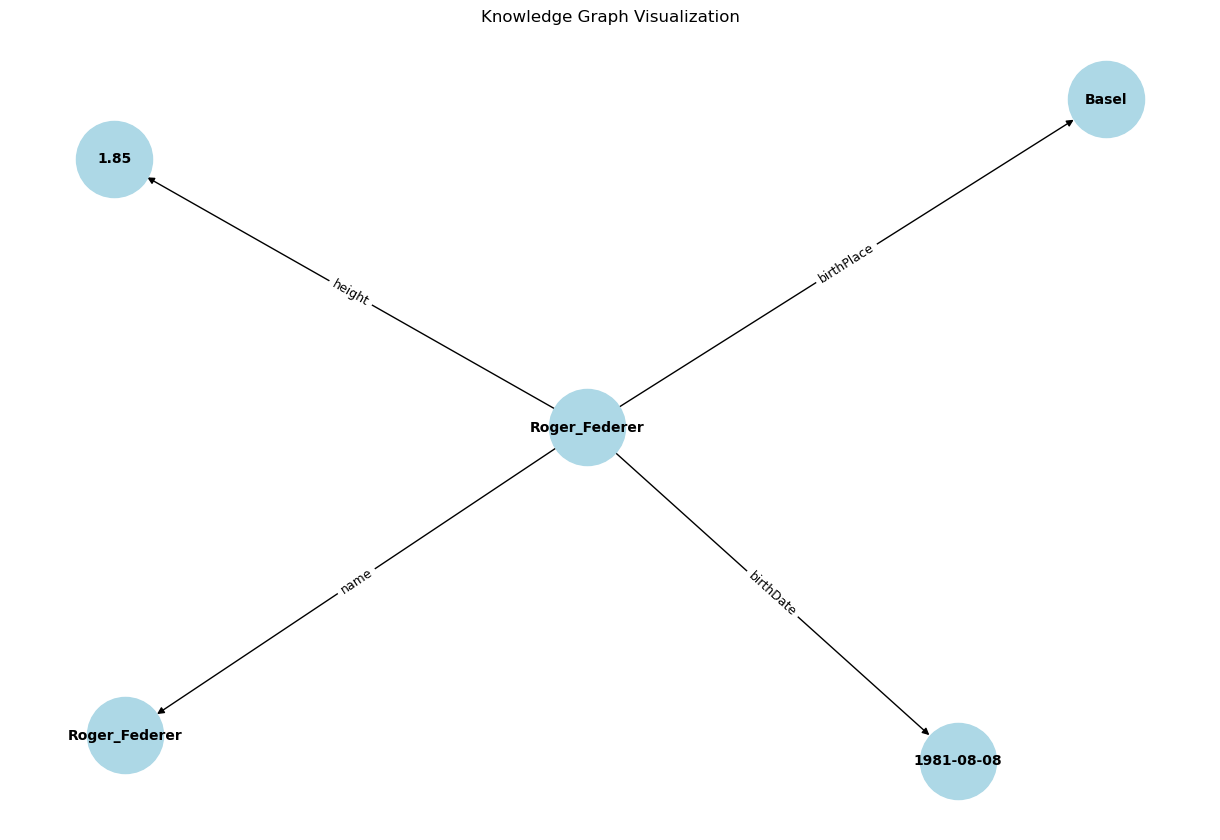

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph

def visualize_knowledge_graph(rdf_graph):
    # Create a directed graph in NetworkX
    nx_graph = nx.DiGraph()

    # Add RDF triples to the NetworkX graph
    for subj, pred, obj in rdf_graph:
        # Simplify labels for display
        subj_label = subj.split('/')[-1]
        pred_label = pred.split('/')[-1]
        obj_label = obj.split('/')[-1] if isinstance(obj, URIRef) else obj

        # Add nodes and edges with labels
        nx_graph.add_node(subj_label)
        nx_graph.add_node(obj_label)
        nx_graph.add_edge(subj_label, obj_label, label=pred_label)

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(nx_graph)  # Positioning for clarity

    # Draw nodes and edges
    nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')

    # Draw edge labels
    edge_labels = {(u, v): d['label'] for u, v, d in nx_graph.edges(data=True)}
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Knowledge Graph Visualization")
    plt.show()

# Example usage with the knowledge graph created for a single player
visualize_knowledge_graph(player_graph)